# Projekt Terawatt

*von Team Coding Agents*


----


## Grundlagen

Simulation der Systemdelays am Energiecampus.

https://github.com/Nikolai-Hlubek/terawatt

In [1]:
import iplantuml
import datetime
import terawatt_model

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
# run at the start of every ipython notebook to use plotly.offline
# this injects the plotly.js source files into the notebook
init_notebook_mode(connected=True)

from IPython.display import IFrame

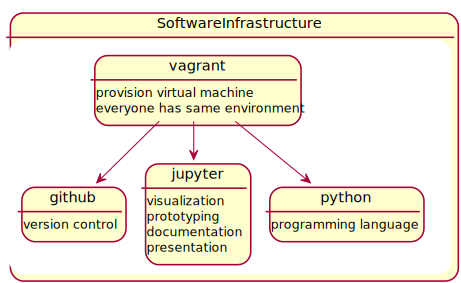

In [2]:
%%plantuml infrastructure

@startuml
skinparam dpi 100

state SoftwareInfrastructure {
    vagrant --> github
    vagrant : provision virtual machine
    vagrant : everyone has same environment
    github : version control
    vagrant --> jupyter
    jupyter : visualization
    jupyter : prototyping
    jupyter : documentation
    jupyter : presentation
    vagrant --> python
    python : programming language
    
}
@enduml

<img src="infrastructure.svg" alt="infrastructure" height="600">

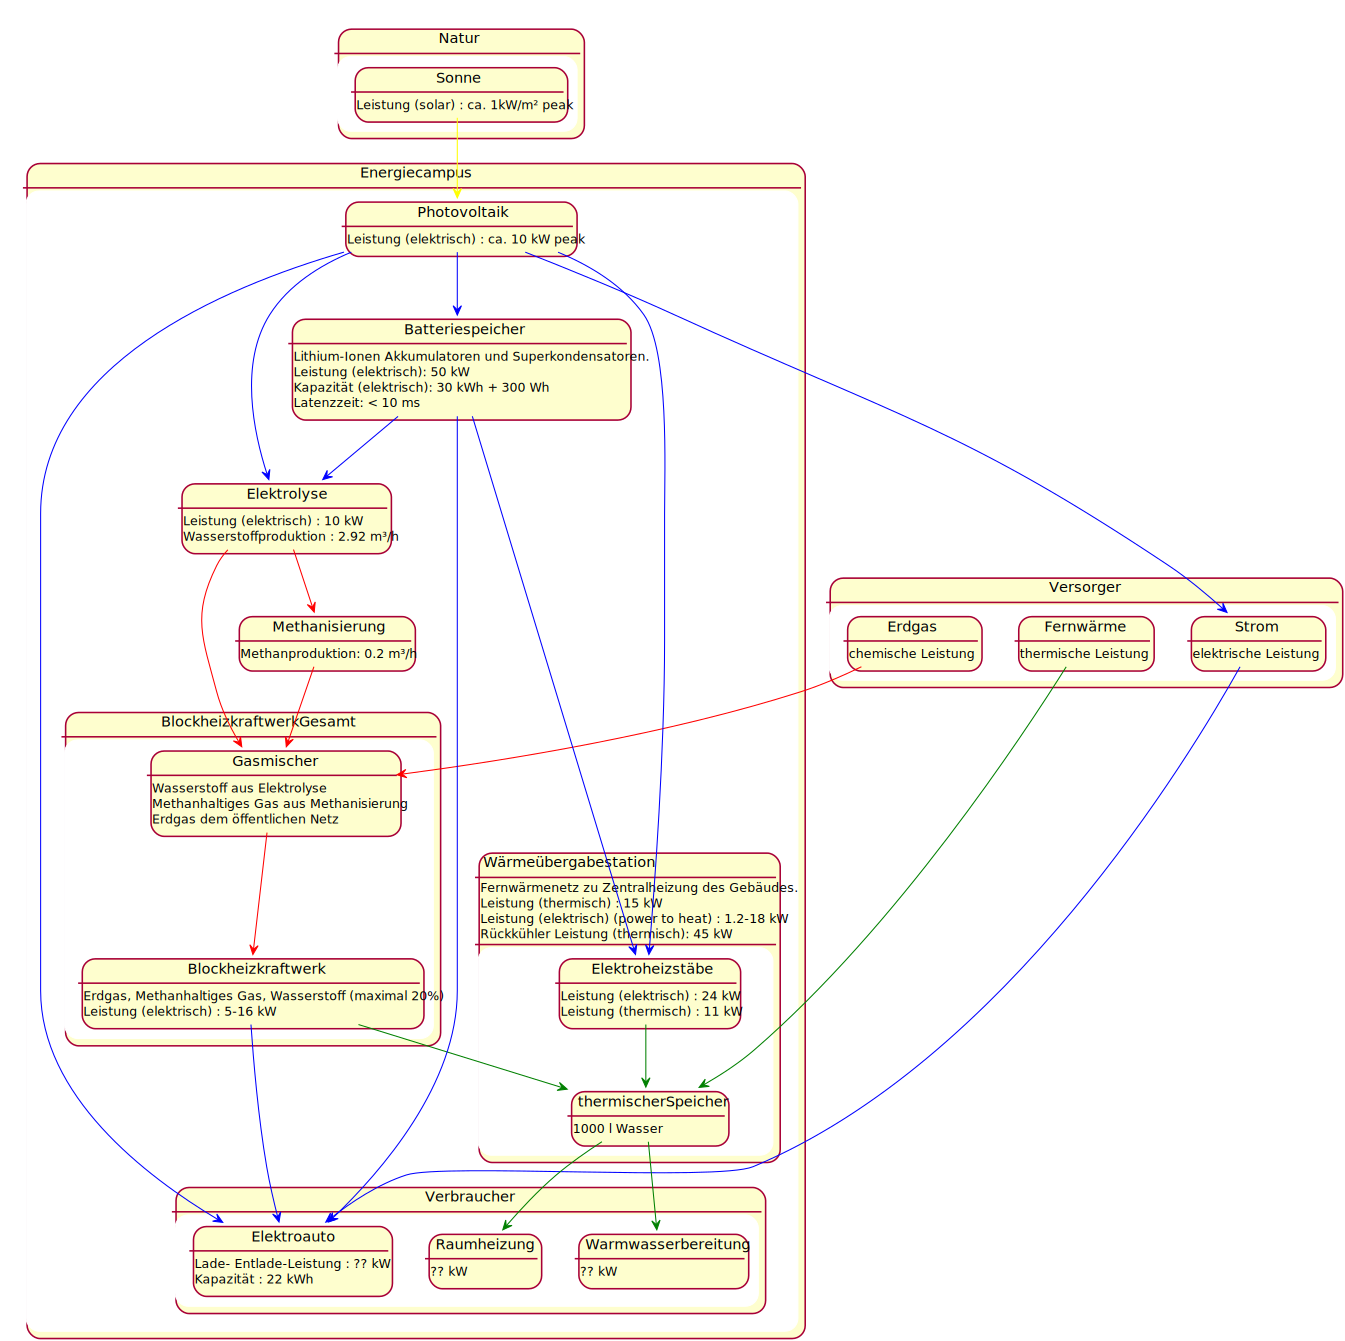

In [3]:
%%plantuml overview

@startuml
skinparam dpi 100


state Energiecampus {

    state Wärmeübergabestation {
        Wärmeübergabestation : Fernwärmenetz zu Zentralheizung des Gebäudes. 
        Elektroheizstäbe : Leistung (elektrisch) : 24 kW
        Elektroheizstäbe : Leistung (thermisch) : 11 kW
        thermischerSpeicher : 1000 l Wasser
    }
    
    state Verbraucher {
        Elektroauto : Lade- Entlade-Leistung : ?? kW
        Elektroauto : Kapazität : 22 kWh
        Raumheizung : ?? kW
        Warmwasserbereitung : ?? kW
    }                  
    
    state BlockheizkraftwerkGesamt {
        Gasmischer : Wasserstoff aus Elektrolyse
        Gasmischer : Methanhaltiges Gas aus Methanisierung
        Gasmischer : Erdgas dem öffentlichen Netz
        Blockheizkraftwerk : Erdgas, Methanhaltiges Gas, Wasserstoff (maximal 20%)        
    }
    

    
    Photovoltaik : Leistung (elektrisch) : ca. 10 kW peak
}

state Natur {
    Sonne -[#yellow]-> Photovoltaik
    Sonne : Leistung (solar) : ca. 1kW/m² peak
}

state Versorger {
    Strom -[#blue]-> Elektroauto 
    Strom : elektrische Leistung
    Erdgas -[#red]-> Gasmischer
    Erdgas : chemische Leistung
    Fernwärme -[#green]-> thermischerSpeicher
    Fernwärme : thermische Leistung
}

state Energiecampus{
    
    Blockheizkraftwerk -[#green]-> thermischerSpeicher
    Blockheizkraftwerk -[#blue]-> Elektroauto
    Blockheizkraftwerk : Leistung (elektrisch) : 5-16 kW

    Gasmischer -[#red]-> Blockheizkraftwerk

    Wärmeübergabestation : Leistung (thermisch) : 15 kW
    Wärmeübergabestation : Leistung (elektrisch) (power to heat) : 1.2-18 kW
    Wärmeübergabestation : Rückkühler Leistung (thermisch): 45 kW

    Batteriespeicher : Lithium-Ionen Akkumulatoren und Superkondensatoren. 
    Batteriespeicher : Leistung (elektrisch): 50 kW
    Batteriespeicher : Kapazität (elektrisch): 30 kWh + 300 Wh
    Batteriespeicher : Latenzzeit: < 10 ms
    Batteriespeicher -[#blue]-> Elektroauto

    Photovoltaik -[#blue]-> Strom
    Photovoltaik -[#blue]-> Elektroauto
    Photovoltaik -[#blue]-> Batteriespeicher
    Photovoltaik -[#blue]-> Elektrolyse
    Photovoltaik -[#blue]-> Elektroheizstäbe
                                                            
    Elektrolyse : Leistung (elektrisch) : 10 kW
    Elektrolyse : Wasserstoffproduktion : 2.92 m³/h
    Batteriespeicher -[#blue]-> Elektrolyse
    Elektrolyse -[#red]-> Gasmischer
    Elektrolyse -[#red]-> Methanisierung

    Methanisierung : Methanproduktion: 0.2 m³/h
    Methanisierung -[#red]-> Gasmischer

    thermischerSpeicher -[#green]-> Warmwasserbereitung
    thermischerSpeicher -[#green]-> Raumheizung

    Elektroheizstäbe -[#green]-> thermischerSpeicher
                                                                                
    Batteriespeicher -[#blue]-> Elektroheizstäbe
}

@enduml 

<img src="overview.svg" alt="Overview" width="700">

### Underlying physical model for each device in the network

- Power is the quantity that is passed around.

In particular:
*power.electrical* , *power.chemical* , *power.thermal* , *power.solar*

- Energy is stored on the devices.

In particular:
*energy.electrical* , *energy.chemical* , *energy.thermal* , *energy.solar*

### Solar irradition

In [4]:
sun_irr = terawatt_model.Sun()

time_start = datetime.datetime(2016, 9, 24, 0, 0, 0, 0)

t = []
r = []
for dt in range(0, 3600*24-1, 60):
    time = time_start + datetime.timedelta(0,dt) # days, seconds
    power = sun_irr.update(time=time)
    t.append(time)
    r.append(power.solar)

# Create a trace
trace = go.Scatter(
    x = t,
    y = r,
    name = 'Solar irradiation',
)
data = [trace]

layout = go.Layout(#title='Solar irradiation', 
                   xaxis=go.XAxis(title='Time of day'),
                   yaxis=go.YAxis(title='Watts per square meter'),
                   showlegend=True,
                  )
fig = go.Figure(data=data, layout=layout)
plot(fig, filename='pictures/solar_irradiation.html', include_plotlyjs=True, show_link=False)

'file:///home/vagrant/what-the-data/pictures/solar_irradiation.html'

In [5]:
IFrame('pictures/solar_irradiation.html', width=900, height=500)

### Charging car directly via photovoltaic array

In [6]:
# Timeconsuming calculation

sun = terawatt_model.Sun()
photovoltaic = terawatt_model.Photovoltaic()
car = terawatt_model.Car()
provider = terawatt_model.Provider()

time_start = datetime.datetime(2016, 9, 24, 0, 0, 0, 0)

t = []
r1 = []
r2 = []
# Run for timestep
for dt in range(0, 3600*24-1, terawatt_model.timestep):
    time = time_start + datetime.timedelta(0,dt) # days, seconds
    
    power = sun.update(time=time)
    power = photovoltaic.update(power)
    power = car.update(power)
    power = provider.update(power)
    
    # Store only each minute
    if dt%60:
        t.append(time)
        r1.append(photovoltaic.power.electrical)
        r2.append(car.energy_now.electrical)

In [7]:
# Create a trace
trace1 = go.Scatter(
    x = t,
    y = r1,
    name = 'Photovoltaic charging power',
)
trace2 = go.Scatter(
    x = t,
    y = r2,
    name = 'Car battery energy',
    line = dict( color = 'green'),
    yaxis='y2',
)
data = [trace1, trace2]

layout = go.Layout(
                xaxis=go.XAxis(title='Time of day'),
                yaxis=go.YAxis(title='W'),
                yaxis2=go.YAxis(
                            title='Wh',
                            #titlefont={color:'rgb(148, 103, 189)'},
                            #tickfont={color:'rgb(148, 103, 189)'},
                            overlaying='y',
                            side='right'
                )
)
fig = go.Figure(data=data, layout=layout)
plot(fig, filename='pictures/car_direct_charging.html', include_plotlyjs=True, show_link=False)

'file:///home/vagrant/what-the-data/pictures/car_direct_charging.html'

In [30]:
print('Excess Energy : ', provider.energy_consumed.electrical, 'Wh')
IFrame('pictures/car_direct_charging.html', width=900, height=500)

Excess Energy :  33396.34264762053 Wh


### Delayed charging of car via battery cluster

In [24]:
# Timeconsuming calculation

sun = terawatt_model.Sun()
photovoltaic = terawatt_model.Photovoltaic()
car = terawatt_model.Car()
provider = terawatt_model.Provider()
battery = terawatt_model.Battery()
time_start = datetime.datetime(2016, 9, 24, 0, 0, 0, 0)

t = []
r1 = []
r2 = []
r3 = []
# Run for timestep
for dt in range(0, 3600*24-1, terawatt_model.timestep):
    time = time_start + datetime.timedelta(0,dt) # days, seconds
    
    power = sun.update(time=time)
    power = photovoltaic.update(power)
    
    # cannot compare against full charge. Due to incremental energies we never reach full charge exactly.
    if time.hour >= 18 and car.energy_now.electrical < 0.99*car.energy_max.electrical:
        power_requested = car.get_power_in_max()
        power = battery.update(power, state='provide', power_requested=power_requested)
        power = car.update(power)
        power = provider.update(power)
    else:
        power = battery.update(power, state='consume')
        power = provider.update(power)
    
    # Store only each minute
    if dt%60:
        t.append(time)
        r1.append(photovoltaic.power.electrical)
        r2.append(battery.energy_now.electrical)
        r3.append(car.energy_now.electrical)

In [25]:
# Create a trace
trace1 = go.Scatter(
    x = t,
    y = r1,
    name = 'Photovoltaic charging power',
)
trace2 = go.Scatter(
    x = t,
    y = r2,
    name = 'Buffer battery energy',
    yaxis='y2',
)
trace3 = go.Scatter(
    x = t,
    y = r3,
    name = 'Car battery energy',
    yaxis='y2',
)
data = [trace1, trace2, trace3]

layout = go.Layout(
                xaxis=go.XAxis(title='Time of day'),
                yaxis=go.YAxis(title='W'),
                yaxis2=go.YAxis(
                            title='Wh',
                            #titlefont={color:'rgb(148, 103, 189)'},
                            #tickfont={color:'rgb(148, 103, 189)'},
                            overlaying='y',
                            side='right'
                )
)
fig = go.Figure(data=data, layout=layout)
plot(fig, filename='pictures/car_delayed_charging.html', include_plotlyjs=True, show_link=False)

'file:///home/vagrant/what-the-data/pictures/car_delayed_charging.html'

In [29]:
print('Excess Energy : ', provider.energy_consumed.electrical, 'Wh')
IFrame('pictures/car_delayed_charging.html', width=900, height=500)

Excess Energy :  33396.34264762053 Wh


### Storing excess energy via electrolysis

In [12]:
# Timeconsuming calculation

sun = terawatt_model.Sun()
photovoltaic = terawatt_model.Photovoltaic()
car = terawatt_model.Car()
provider = terawatt_model.Provider()
battery = terawatt_model.Battery()
electrolysis = terawatt_model.Electrolysis()
time_start = datetime.datetime(2016, 9, 24, 0, 0, 0, 0)

t = []
r1 = []
r2 = []
r3 = []
r4 = []
# Run for timestep
for dt in range(0, 3600*24-1, terawatt_model.timestep):
    time = time_start + datetime.timedelta(0,dt) # days, seconds
    
    power = sun.update(time=time)
    power = photovoltaic.update(power)
    
    # cannot compare against full charge. Due to incremental energies we never reach full charge exactly.
    if time.hour >= 18 and car.energy_now.electrical < 0.99*car.energy_max.electrical:
        power_requested = car.get_power_in_max()
        power = battery.update(power, state='provide', power_requested=power_requested)
        power = car.update(power)
    else:
        power = battery.update(power, state='consume')
    
    power = electrolysis.update(power, state='consume')
    power = provider.update(power)
    
    # Store only each minute
    if dt%60:
        t.append(time)
        r1.append(photovoltaic.power.electrical)
        r2.append(battery.energy_now.electrical)
        r3.append(car.energy_now.electrical)
        r4.append(electrolysis.energy_now.chemical)

In [13]:
# Create a trace
trace1 = go.Scatter(
    x = t,
    y = r1,
    name = 'Photovoltaic charging power',
)
trace2 = go.Scatter(
    x = t,
    y = r2,
    name = 'Buffer battery energy',
    yaxis='y2',
)
trace3 = go.Scatter(
    x = t,
    y = r3,
    name = 'Car battery energy',
    yaxis='y2',
)
trace4 = go.Scatter(
    x = t,
    y = r4,
    name = 'Electrolysis chemical energy',
    yaxis='y2',
)
data = [trace1, trace2, trace3, trace4]

layout = go.Layout(
                xaxis=go.XAxis(title='Time of day'),
                yaxis=go.YAxis(title='W'),
                yaxis2=go.YAxis(
                            title='Wh',
                            #titlefont={color:'rgb(148, 103, 189)'},
                            #tickfont={color:'rgb(148, 103, 189)'},
                            overlaying='y',
                            side='right'
                )
)
fig = go.Figure(data=data, layout=layout)
plot(fig, filename='pictures/car_delayed_charging_electrolysis.html', include_plotlyjs=True, show_link=False)

'file:///home/vagrant/what-the-data/pictures/car_delayed_charging_electrolysis.html'

In [32]:
print('Excess Energy : ', provider.energy_consumed.electrical, 'Wh')
IFrame('pictures/car_delayed_charging_electrolysis.html', width=900, height=500)

Excess Energy :  33396.34264762053 Wh


### Methanization of excess energy

In [15]:
# Timeconsuming calculation

sun = terawatt_model.Sun()
photovoltaic = terawatt_model.Photovoltaic()
car = terawatt_model.Car()
provider = terawatt_model.Provider()
battery = terawatt_model.Battery()
electrolysis = terawatt_model.Electrolysis()
methanization = terawatt_model.Methanization()
time_start = datetime.datetime(2016, 9, 24, 0, 0, 0, 0)

t = []
r1 = []
r2 = []
r3 = []
r4 = []
r5 = []
# Run for timestep
for dt in range(0, 3600*24-1, terawatt_model.timestep):
    time = time_start + datetime.timedelta(0,dt) # days, seconds
    
    power = sun.update(time=time)
    power = photovoltaic.update(power)
    
    # cannot compare against full charge. Due to incremental energies we never reach full charge exactly.
    if time.hour >= 18 and car.energy_now.electrical < 0.99*car.energy_max.electrical:
        power = battery.update(power, state='provide', power_requested=car.get_power_in_max())
        power = car.update(power)
    else:
        power = battery.update(power, state='consume')

    power = electrolysis.update(power, state='both', power_requested=methanization.get_power_in_max())
    power = methanization.update(power, state='consume')
    power = provider.update(power)
    
    # Store only each minute
    if dt%60:
        t.append(time)
        r1.append(photovoltaic.power.electrical)
        r2.append(battery.energy_now.electrical)
        r3.append(car.energy_now.electrical)
        r4.append(electrolysis.energy_now.chemical)
        r5.append(methanization.energy_now.chemical)

In [16]:
# Create a trace
trace1 = go.Scatter(
    x = t,
    y = r1,
    name = 'Photovoltaic charging power',
)
trace2 = go.Scatter(
    x = t,
    y = r2,
    name = 'Buffer battery energy',
    yaxis='y2',
)
trace3 = go.Scatter(
    x = t,
    y = r3,
    name = 'Car battery energy',
    yaxis='y2',
)
trace4 = go.Scatter(
    x = t,
    y = r4,
    name = 'Electrolysis chemical energy',
    line = dict( color = 'red' ),
    yaxis='y2',
)
trace5 = go.Scatter(
    x = t,
    y = r5,
    name = 'Methanization chemical energy',
    line = dict( color = 'violett' ),
    yaxis='y2',
)
data = [trace1, trace2, trace3, trace4, trace5]

layout = go.Layout(
                xaxis=go.XAxis(title='Time of day'),
                yaxis=go.YAxis(title='W'),
                yaxis2=go.YAxis(
                            title='Wh',
                            #titlefont={color:'rgb(148, 103, 189)'},
                            #tickfont={color:'rgb(148, 103, 189)'},
                            overlaying='y',
                            side='right'
                )
)
fig = go.Figure(data=data, layout=layout)
plot(fig, filename='pictures/car_delayed_charging_methanization.html', include_plotlyjs=True, show_link=False)

'file:///home/vagrant/what-the-data/pictures/car_delayed_charging_methanization.html'

In [34]:
print('Excess Energy : ', provider.energy_consumed.electrical, 'Wh')
IFrame('pictures/car_delayed_charging_methanization.html', width=900, height=500)

Excess Energy :  33396.34264762053 Wh


### Two Cars - Cogeneration required

In [18]:
import iplantuml
import datetime
import terawatt_model

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
# run at the start of every ipython notebook to use plotly.offline
# this injects the plotly.js source files into the notebook
init_notebook_mode(connected=True)


# Timeconsuming calculation

sun = terawatt_model.Sun()
photovoltaic = terawatt_model.Photovoltaic()
car1 = terawatt_model.Car()
car2 = terawatt_model.Car()
provider = terawatt_model.Provider()
battery = terawatt_model.Battery()
electrolysis = terawatt_model.Electrolysis()
methanization = terawatt_model.Methanization()
cogeneration = terawatt_model.Cogeneration()
time_start = datetime.datetime(2016, 9, 24, 0, 0, 0, 0)

t = []
r1 = []
r2 = []
r3 = []
r4 = []
r5 = []
r6 = []
r7 = []
# Run for timestep
for dt in range(0, 3600*24-1, terawatt_model.timestep):
    time = time_start + datetime.timedelta(0,dt) # days, seconds
    
    power = sun.update(time=time)
    power = photovoltaic.update(power)
    
    power = battery.update(power, state='consume')
    power = electrolysis.update(power, state='both', power_requested=methanization.get_power_in_max())
    power = methanization.update(power, state='consume')
    
    if time.hour >= 18:
        # cannot compare against full charge. Due to incremental energies we never reach full charge exactly.
        if car1.energy_now.electrical < 0.99*car1.energy_max.electrical:
            power_requested = car1.get_power_in_max()
        if car2.energy_now.electrical < 0.99*car2.energy_max.electrical:
            power_requested.electrical += car2.get_power_in_max().electrical
        
        power_requested.chemical += cogeneration.power_conversion_electrical_to_chemical(power_requested.electrical).chemical
        power = methanization.update(power, state='provide', power_requested=power_requested)
        power = cogeneration.update(power, state='both', power_requested=power_requested)
        power_requested.electrical -= power.electrical
        power = battery.update(power, state='provide', power_requested=power_requested)
        
        power = car1.update(power)
        power = car2.update(power)
    else:
        power = methanization.update(power, state='provide', power_requested=methanization.get_power_out_max())
        power = cogeneration.update(power, state='consume')
    
    power = provider.update(power)
    
    # Store only each minute
    if dt%60:
        t.append(time)
        r1.append(photovoltaic.power.electrical)
        r2.append(battery.energy_now.electrical)
        r3.append(car1.energy_now.electrical)
        r4.append(car2.energy_now.electrical)
        r5.append(electrolysis.energy_now.chemical)
        r6.append(cogeneration.energy_now.chemical)
        r7.append(cogeneration.power.electrical)

In [19]:
# Create a trace
trace1 = go.Scatter(
    x = t,
    y = r1,
    name = 'Photovoltaic charging power',
)
trace2 = go.Scatter(
    x = t,
    y = r2,
    name = 'Buffer battery energy',
    yaxis='y2',
)
trace3 = go.Scatter(
    x = t,
    y = r3,
    name = 'Car 1 battery energy',
    yaxis='y2',
)
trace4 = go.Scatter(
    x = t,
    y = r4,
    name = 'Car 2 battery energy',
    line = dict( color = 'black', dash = 4 ),
    yaxis='y2',
)
trace5 = go.Scatter(
    x = t,
    y = r5,
    name = 'Electrolysis chemical energy',
    line = dict( color = 'red' ),
    yaxis='y2',
)
trace6 = go.Scatter(
    x = t,
    y = r6,
    name = 'Cogeneration chemical energy',
    line = dict( color = 'violett'),
    yaxis='y2',
)
trace7 = go.Scatter(
    x = t,
    y = r7,
    name = 'Cogeneration power',
)
data = [trace1, trace2, trace3, trace4, trace5, trace6, trace7]

layout = go.Layout(
                xaxis=go.XAxis(title='Time of day'),
                yaxis=go.YAxis(title='W'),
                yaxis2=go.YAxis(
                            title='Wh',
                            #titlefont={color:'rgb(148, 103, 189)'},
                            #tickfont={color:'rgb(148, 103, 189)'},
                            overlaying='y',
                            side='right'
                )
)
fig = go.Figure(data=data, layout=layout)
plot(fig, filename='pictures/cars_delayed_charging_cogeneration.html', include_plotlyjs=True, show_link=False)

'file:///home/vagrant/what-the-data/pictures/cars_delayed_charging_cogeneration.html'

In [36]:
print('Excess Energy : ', provider.energy_consumed.electrical, 'Wh')
IFrame('pictures/cars_delayed_charging_cogeneration.html', width=900, height=500)

Excess Energy :  33396.34264762053 Wh


In [21]:
#class Main:
#    # List of devices
#    # Sun is a device
#    devices_usedBy={}
#    devices_usedBy[block1]=bmw1
#    # List of externals
#    # List of output for next step
#    # List of state of current step
#    # List of input current step
#    
#    # Magic knowledge about connecting devices
#    # foreach d in devices:
#    #     foreach dev in devices_usedBy[d]:
#    #         dev.conversion(d.power_out)
#    
#    # Update externals

In [22]:
from terawatt_model.basics import Consumer, Producer, Broker

class BMW(Consumer):
    def __init(self, broker):
        super()
        self.broker=broker

class Battery(Consumer, Producer):
    pass

class Main():
    def __init__(self):
        broker=Broker()
        bmw=BMW(broker)
        battery=Battery()
        self.consumer=[bmw, battery]
        self.producer=battery
        
    def run(self):
        time=0
        while(true):
            time=time+1
            for c in self.consumer:
                c.update()
            broker.broadcast()
            for p in self.producer:
                p.update()